# Forecasting Chip Prices 

Supply chain disruptions, COVID, increasing inflation and geopolitical stresses are damaging companies’ returns. Never has it been more important for analysts and data scientists to provide actionable predictions and insights into the market. This brings data-driven decision making and price forecasting to the heart of many firms. However, time-series and forecasting are complex disciplines within data science, requiring specialized knowledge of multiple techniques. But where to start really? There are many great resources out there that cover the basics of time series, from basic statistics all the way to in-depth deep learning tutorials. While many novice data scientists will jump straight into trying to build a complex deep learning model, it’s often better to take a step back, re-frame the problem and start with simpler methods. 

Many companies and teams simply won’t have enough data to do deep learning. Therefore, in this article we will cover a common machine learning approach to help you get started quickly. Thankfully, we don’t have to reinvent the wheel, as we are able to use python packages such as 
__Darts__, which allow us to rapidly develop and test a range of forecasting models and techniques.

In this article we will focus on forecasting the prices of chips (the potato kind) in the United States. For this we will use some publicly available price data from the [Federal Reserve Bank of St. Louis](https://fred.stlouisfed.org/). The aim is to generate a forecast model for the monthly potato chip data which can predict prices 3-months into the future. For this we will use the __random forest__ approach, which one could think of as the dynamite fishing approach in forecasting. Even though a random forest is a very powerful machine learning technique, even a beginner can rapidly deploy a working model. 


In [1]:
import pandas as pd

import warnings
import pathlib

from darts.timeseries import TimeSeries
from darts.models import RandomForest
from darts.metrics import mape

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("dark")
plt.style.use("dark_background")
plt.rcParams['figure.facecolor'] = '#151934'
plt.rcParams['axes.facecolor'] = '#151934'
plt.rcParams.update({'axes.facecolor':'#151934'})
sns.set_palette('pastel')
sns.set_context('talk')

warnings.simplefilter(action='ignore', category=FutureWarning)

[2022-06-09 08:08:58,036] WARNING | darts.models | Support for AutoARIMA, BATS and TBATS is not available.To enable it, install u8darts[pmdarima] or u8darts[all].
2022-06-09 08:08:58 darts.models WARNING: Support for AutoARIMA, BATS and TBATS is not available.To enable it, install u8darts[pmdarima] or u8darts[all].
[2022-06-09 08:08:58,041] WARNING | darts.models | Support for Facebook Prophet is not available. To enable it, install "darts", "u8darts[prophet]" or "u8darts[all]" (with pip);or "u8darts-all" (with conda).
2022-06-09 08:08:58 darts.models WARNING: Support for Facebook Prophet is not available. To enable it, install "darts", "u8darts[prophet]" or "u8darts[all]" (with pip);or "u8darts-all" (with conda).
[2022-06-09 08:08:58,045] WARNING | darts.models | Support for Torch based models not available. To enable them, install "darts", "u8darts[torch]" or "u8darts[all]" (with pip); or "u8darts-torch" or "u8darts-all" (with conda).
2022-06-09 08:08:58 darts.models WARNING: Support

First, we will read in the data from our local path using the packages __pathlib__ and __pandas__. The data used in this article can be downloaded for free from the website of the [Federal Reserve Bank of St. Louis](https://fred.stlouisfed.org/). In addition to the chips data, we will be using two further data sources to help us generate the forecast. The average potato chip price data is our target for the forecast, while the other two data sets are used as features or “past covariates”, data which contains useful information about how the target will develop in the future. If you want to follow along with the tutorial we suggest downloading the files as CSVs to your local machine. Below is a list of the datasets used in this article:

* [Average Price: Potato Chips (Cost per 16 Ounces) in U.S. City Average](https://fred.stlouisfed.org/series/APU0000718311).
* [S&P/Case-Shiller U.S. National Home Price Index](https://fred.stlouisfed.org/series/CSUSHPISA)
* [Consumer Price Index for All Urban Consumers: Admission to Movies, Theatres, and Concerts in U.S. City Average](https://fred.stlouisfed.org/series/CUSR0000SS62031)

The dataset comes with cryptic names for the series which we simply rename in the article to make handling the data easier for us. Additionally, we must convert the date column to a datetime object and set it to be the index, as required by __Darts__ package. To simplify the code and avoid repetition we will use a data dictionary to store the target and feature names. We will loop through the dictionary on our local path, and read, rename and process the data set before putting them together into a combined pandas DataFrame. As part of this we will also remove any missing values, since several machine learning models have problems handling missing values.

In [24]:
path_to_data = pathlib.Path.cwd()

# Create dictionary with the overall settings 
data_dict = {
    "target": ("APU0000718311", "avg_chip_price"),
    "feature1": ("CUSR0000SS62031", "cpi_movies"),
    "feature2": ("CSUSHPISA", "home_price_index"),
    }

combine_data_list = list() # Create an empty list for the dataframes that are to be combined.
feature_names = list() # Create an empty list for the feature names

# Read in all files from data_dict
for key, values in data_dict.items(): 
    df = pd.read_csv(pathlib.Path(path_to_data).joinpath(values[0]+".csv"))
    df.columns = ["date", values[1]] # Rename dataframe cols
    df["date"] = pd.to_datetime(df["date"]) # Convert to datetime
    df.set_index("date", inplace=True) # Set date to index.
    data_dict[key] = [values, df]
    combine_data_list.append(df)
    if key == "target":
        target_name = values[1]
    else:
        feature_names.append(values[1])  

# Combine the datasets together
df_combined = pd.concat(combine_data_list, axis=1).dropna()
df_combined.head()

,avg_chip_price,cpi_movies,home_price_index
date,,,
1999-01-01,3.217,102.7,93.208
1999-02-01,3.223,103.7,93.671
1999-03-01,3.249,104.2,94.217
1999-04-01,3.264,104.8,94.785
1999-05-01,3.212,106.4,95.345


There are numerous possible strategies to generate a forecast. In this article we will focus on two strategies using the random forest regressor model. First, we will generate a univariate forecast. Second, we will generate a multivariate forecast. The univariate model uses only the historical chip price data to forecast the future chip prices. The multivariate forecast uses the historical chip prices plus two other features, the past covariates. These past covariates are used to improve the explainability of the forecast by drawing on the underlying economic factors that are supposed to influence the price (e.g. supply and demand). 

Before we can get started with our forecast it is advisable to explore and visualize the time-series data. There are many different methods that can be deployed to analyse time series data. In this article we will focus on the overall seasonality and trend of the chip prices, and we will conduct a visual inspection of the full datasets.  

First, it is recommended to plot the time series data alongside the covariates to help identify any correlated behaviour. Here it is recommended to rescale the series to a common magnitude, to make them easier to compare. For this we will deploy a MinMax scaler from the __scikit-learn__ package.

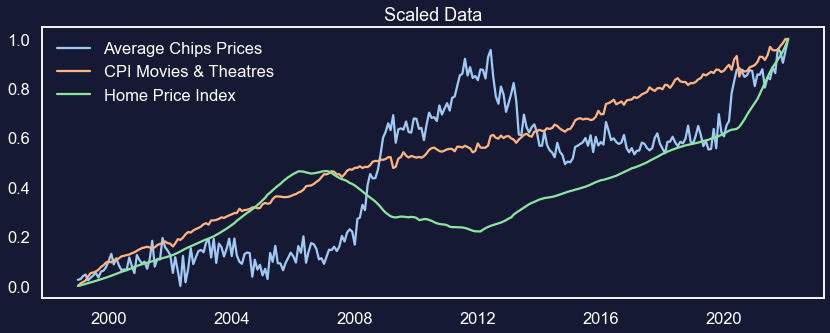

In [27]:
scaler = MinMaxScaler() # Initiate scaler

col_names = df_combined.columns # Rename the columns 

# Apply the scaler
df_combined_scaled = df_combined.copy()
df_combined_scaled[col_names] = scaler.fit_transform(df_combined_scaled[col_names])

# Plot the data
fig, ax = plt.subplots(figsize=(14, 5))

ax.set_title("Scaled Data")
ax.plot(df_combined_scaled["avg_chip_price"], label="Average Chips Prices")
ax.plot(df_combined_scaled["cpi_movies"], label="CPI Movies & Theatres")
ax.plot(df_combined_scaled["home_price_index"], label="Home Price Index")
ax.legend()

plt.show()

From the historical time-series, we observe a gradual increase in average chips prices from 1980 up to today. We are also able to identify big price shifts in 2008, and 2020. Overall, we can observe some degree of correlation between average chip prices and both CPI movies & theatre and the home price index. There are many statistical ways to test correlation and relationships between the different series, but we will leave these to a later article.

Another common method to explore time series is to break down the time series into different components. The easiest approach is to separate the timeseries into trend, seasonality, and residuals with the __statsmodels__ package. Below we will be using an additive decomposition that follows the following equation, where Y(t) describes the time series as the sum of trend, seasonality, and residuals. 

$Y(t) = Trend + Seasonality + Residuals $

Overall, we can identify a strong trend component in our time series, low levels of seasonality and higher residuals. The information from this initial exploration could help data scientists to augment and tune the data with relevant additional and derived features. 

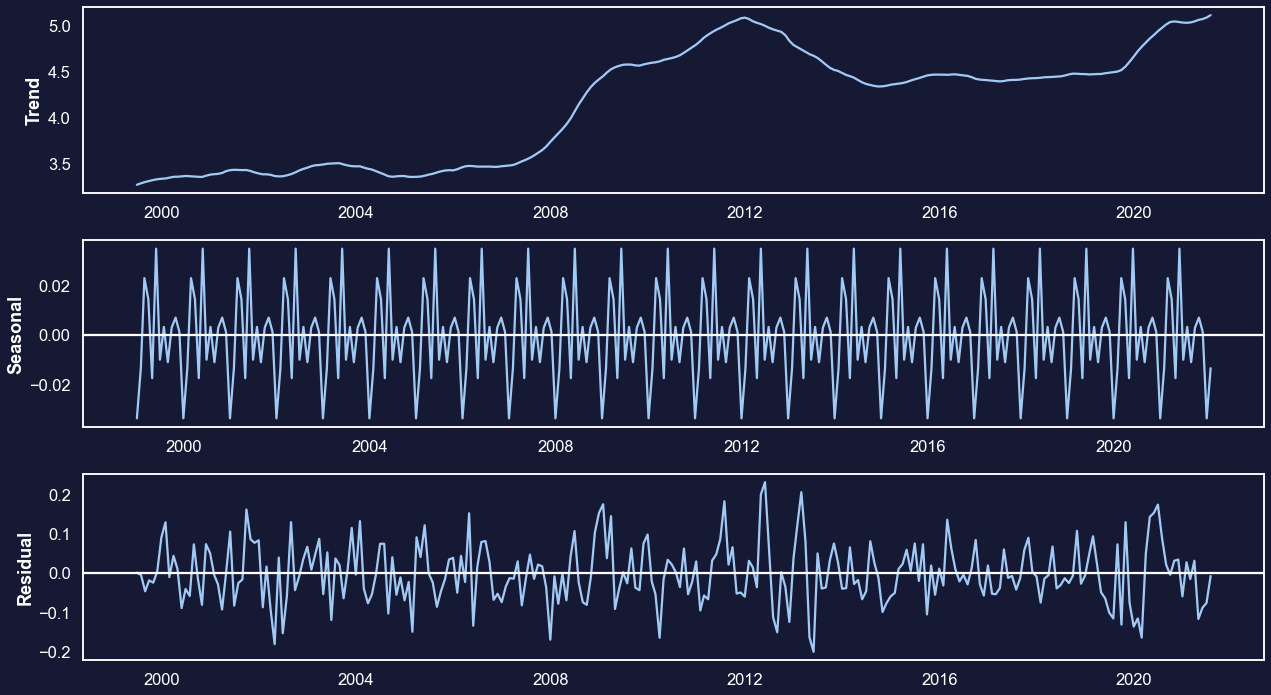

In [28]:
chips_decompose = seasonal_decompose(df_combined[target_name])

fig, ax = plt.subplots(figsize=(18, 10), nrows=3)

ax[0].plot(chips_decompose.trend, label="trend")
ax[0].set_ylabel("Trend")

ax[1].plot(chips_decompose.seasonal, label="seasonal")
ax[1].set_ylabel("Seasonal")

ax[2].plot(chips_decompose.resid, label="residual")
ax[2].set_ylabel("Residual")

ax[1].axhline(color="white")
ax[2].axhline(color="white")

fig.tight_layout()
plt.show()

## Univariate Forecasting Approach

In the first forecasting approach we will forecast the chips prices 3-months ahead using a univariate model, meaning using the historical chip prices to forecast the future. This is a common technique deployed in many traditional statistical models and usually offers good accuracies for short time horizons. Researchers often highlight the power of traditional statistical forecast models even today (e.g. ARIMA, Exponential smoothing, etc.). Here, the statistical models regularly outperform machine learning and deep learning forecast models. The drawback not exclusively lies in the generalizability of the models often being tailored to one specific forecasting task as well as the overall explainability.   While a random forest is not a traditional forecast model we will use the concept to highlight how a machine learning model can be used to forecast a single time-series.

To generate a univariate time forecasting model, we will use the built in functions of the _darts_ package. For this, we first have to convert the _pandas_ dataframe into a __Darts__ TimeSeries object. Then we split the data into train and test sets for model training and performance evaluation.

,avg_chip_price
date,
1999-01-01,3.217
1999-02-01,3.223
1999-03-01,3.249
1999-04-01,3.264
1999-05-01,3.212
...,...
2021-10-01,5.273
2021-11-01,5.246
2021-12-01,5.150


In [48]:
chips_series = TimeSeries.from_dataframe(df_combined[[target_name]])
chips_series.head()

train_test_split_row = int(len(chips_series)*0.2)
chips_train, chips_test = chips_series[:-train_test_split_row], chips_series[-train_test_split_row:]

Now we get to the most interesting part, the modelling. Here, we first have to define a random forest forecasting model. Luckily, while random forest models in packages such as __scikit-learn__ require additional packaging before they can be used for forecasting, __Darts__ already comes out of the box with a random forest regression model which has been pre-configured to forecast time series. For forecasting, the time series dataset needs to be converted into a supervised learning problem by lagging and leading the time-series columns, so that the model receives a window of past values as input, and a future value or values as the target output. __Darts__ does the heavy lifting for us with their RegressionModel and RandomForest classes, which handle creating lags for the target variable and any covariates. 

In our random forest model, we specify 12-lags. The 12-lags mean we are shifting back the time-series by 12-months in 1-month steps, creating 12 columns. With 12-lags we are able to cover the variation of a full year. Additionally, we set the output chunk length to 3, meaning that we forecast three timesteps ahead at once with our model. 

Generally, we use the test set to determine the accuracy of the model by generating forecasts using historical data up to a given date as input, generating forecasts and comparing the forecasts with what actually happened. However, in the real-world we would also retrain our model with the most recent data available before generating a forecast, so to test the model we systematically loop through the test set, training the model on all data up to a date, forecasting three months ahead, storing the results, then moving the window of input data on by a set number of months, and repeating the process of training the model and forecasting. This is continued until we reach the end of the test-set to get a full set of test forecasts. 


In [49]:
# Define the model
uni_model = RandomForest(
    lags=12,
    n_estimators=200,
    output_chunk_length=3
)

# Fit training data
uni_model.fit(
    series=chips_train
)

# Create historical forecast for test data
chips_forecast_test = uni_model.historical_forecasts(
    chips_test,
    forecast_horizon=3
)

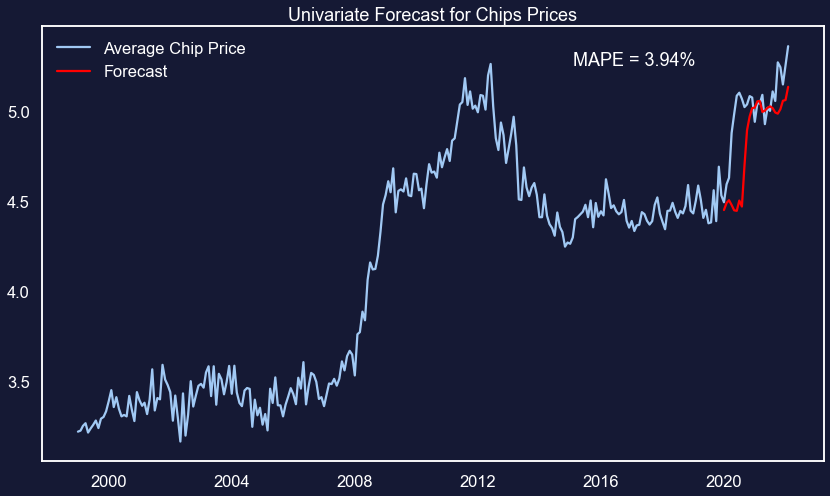

In [50]:
fig, ax = plt.subplots(figsize=(14,8))

ax.set_title("Univariate Forecast for Chips Prices")

ax.plot(chips_series.pd_dataframe(), label="Average Chip Price")
ax.plot(chips_forecast_test.pd_dataframe(), label='Forecast', color="red")
ax.legend()
ax.annotate(
    f"MAPE = {round(mape(chips_test, chips_forecast_test),2)}%", 
    xy=(
        chips_series.pd_dataframe().index[-train_test_split_row-30], 
        chips_series.pd_dataframe().max()-0.02*chips_series.pd_dataframe().max()
    )
)

plt.show()

In our 3-month forecast we achieved an overall performance of 2.97% Mean Absolute Percentage Error (MAPE). This is already pretty good, since the model was only based on the target series. To improve results further, we could use the __gridsearch__ method of the __Darts__ model to optimize the random forest model’s hyperparameters to improve the model performance. Another way is to utilize additional data in a multivariate forecast. 

## Multivariate Forecast 

Next, we will leverage the power of machine learning by using multiple timeseries to generate our forecast and improve the model accuracy. In the multivariate model we will combine the average potato chip prices with the series CPI movies & theatres (which is an index of the cost of admission to movies and theaters), and the US house price index. The additional features are called __past covariates__ in the _Darts_ package, as they contain information that is not available at the future time points, we are trying to forecast. It is also possible to include __future covariates__, which contain information that is known about the future, such as national holidays or other predictable factors, but we will not use these here.

In the initial section we converted the dataframe with the target variable into a TimeSeries object so that it can be used in the Darts model. We will repeat this with the combined dataframe, creating a TimeSeries object that contains multiple series which we can parse as past covariates. We also have to split the new TimeSeries object into train and test sets, as before.

In [8]:
combined_series = TimeSeries.from_dataframe(df=df_combined)

train_test_split_row = int(len(combined_series)*0.2)
combined_train, combined_test = combined_series[:-train_test_split_row], combined_series[-train_test_split_row:]

Next, we will generate the model object again using a similar configuration as used previously. The difference in this instance is that we are also specifying the lags of the past covariates. 

In the model training we will parse the chip prices as the target variable and the CPI movies & theatres and house price index as the past covariates. We then create the historical forecast over the test using the same approach as used for the univariate forecasting model. We then visualize the results and calculate the MAPE.

In [20]:
# Define the model
multy_model = RandomForest(
    lags=12,
    lags_past_covariates=12,
    n_estimators=200,
    output_chunk_length=3
)

# Fit training data
multy_model.fit(
    series=combined_train[target_name],
    past_covariates=combined_train[feature_names]
)

# Create historical forecast for test data
combined_forecast_test = multy_model.historical_forecasts(
    series=combined_test[target_name],
    past_covariates=combined_test[feature_names],
    forecast_horizon=3
)

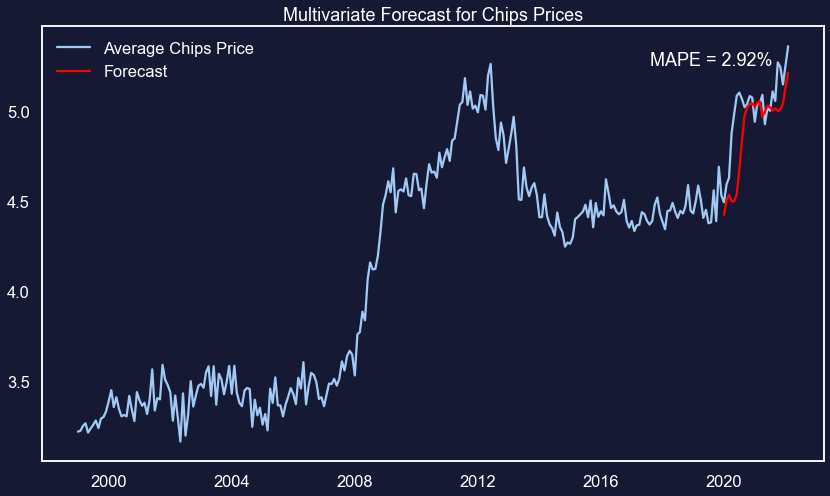

In [21]:
fig, ax = plt.subplots(figsize=(14,8))

ax.set_title("Multivariate Forecast for Chips Prices")

ax.plot(combined_series.pd_dataframe()[target_name], label="Average Chips Price")
ax.plot(combined_forecast_test.pd_dataframe(), label='Forecast', color="red")
ax.legend()
ax.annotate(
    f"MAPE = {round(mape(combined_test[target_name], combined_forecast_test), 2)}%", 
    xy=(
        combined_series.pd_dataframe().index[-train_test_split_row], 
        combined_series.pd_dataframe()[target_name].max()-0.02*combined_series.pd_dataframe()[target_name].max()
    )
)

plt.show()

With the multivariate forecasting model, the error only slightly decreased,  to 2.88% from 2.97%. This is often the case when using additional unscaled sources to forecast. So, the question posed is the U.S. house price index and the CPI for movies and theaters a good indicator for forecasting average chip prices? Not necessarily. When choosing predictive covariates, data scientists should tread cautiously, since correlation does not necessarily equate to causation or predictive value.

In this example, we looked for covariate data by finding series that had a similar overall trend to the target series, indicating some degree of correlation. In   a real-life forecasting application however, we would build the forecast using multidisciplinary knowledge, consulting industry, supply chain and pricing experts as well as data scientists. In this potato chip price forecasting example, we ignored the underlying market considerations that could help choose predictive data sources, such as supply, demand, economic factors and the geopolitical situation.  

Nonetheless, we can conclude our forecasting exercise by deploying our multivariate forecast to predict the future. For this, we will retrain our multivariate model on all the historical data, in order to include the most recent information that is available to us. Here we can hopefully capture things like the effects of a recent pandemic or a war.


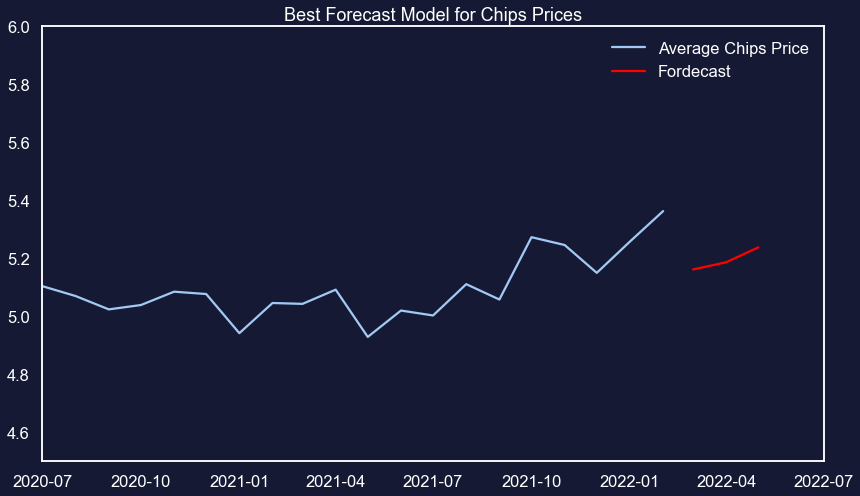

In [11]:
# Fit training data
multy_model.fit(
    series=combined_series[target_name],
    past_covariates=combined_series[feature_names]
)

chips_forecast = multy_model.predict(n=3)

# Vizualize results:
fig, ax = plt.subplots(figsize=(14,8))

ax.set_title("Best Forecast Model for Chips Prices")

ax.plot(combined_series.pd_dataframe()[target_name], label="Average Chips Price")
ax.plot(chips_forecast.pd_dataframe(), label='Fordecast', color="red")
ax.legend()

ax.set_ylim(4.5, 6)
ax.set_xlim(combined_series.pd_dataframe().index[-20], chips_forecast.pd_dataframe().index[-1]+pd.offsets.MonthBegin(2))

plt.show()

## Summary

This blogpost should give you a good idea how to easily apply a random forest model to forecast prices using either a multivariate or univariate strategy. In this example we forecast potato chip prices with a 3-month time horizon. Overall, we achieved a slightly better performance with the multivariate model compared to the univariate model.
There are still multiple steps we can take to overall improve the model accuracy:
* Hyperparameter optimization: We have not covered this in the article in detail, but each model has a range of additional parameters we can tweak to improve the forecast accuracy.
* Detailed value chain mapping and data sourcing to find more relevant data sources. 
* Try out forecast models other than random forest.

Alternatively, you can come and check us out over at [Forecasty.AI]( forecasty.ai), where we are combining best-of-class machine learning, statistical and deep learning models to generate no-code commodity price forecasts.
